Lending Club is a "Market Place Lender" which allows an individual to apply for a personal loan to be filled by the market, as opposed to a bank or other specialty lender.   They have grown in success and to date have closed over $3Bn in loans.    Lending Club has made loan and performance information freely available on their website. 

The data is available on the Lending Club website (https://www.lendingclub.com/info/download-data.action).   I manually downloaded the CSV files and stored them locally.   I am using only one subset of the total lending club data.  

My objectives in this project are threefold:
    i) Learn how to view, clean and manipulate large datasets;
    ii)Develop intuition for fitting estimators to the data;
    iii) What are the best predictors of borrower default? 
    iv) What rates do borrowers pay versus their other financial options?
    v) What are the best predictors of early borrower repayment? 
    vi) Start to develop a better way to predict creditworthiness of borrowers beyond the standard methods (eg, FICO); 
        a) For example, can we parse their loan purpose comments to develop a predictor of default?
        b) Can I take location information (eg, via zip codes) to get a better understanding the regional economy? 
        c) Ultimately, I would like to also use complementary external data sources to allow better prediction. 

## AS OF THE END DATE OF THE COURSE:  
A lot of time has been spent on cleaning, scrubbing, and understanding the organization of the data.   I had to generate some calculated features, and further projects include parsing the text fields.   


 

In [1]:
# load relevant libraries
# This Workbook assumes the presence of a cleaned Lending Club file.   For more details on cleaning
# And calculated features, see xxx

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns


%matplotlib inline

lcd_temp = pd.read_csv("/Users/Glenn/Documents/LendingClub/LendingClub_07-12_CLEANED.csv", 
                       parse_dates=['last_pymnt_date','issue_date',
                                    'last_credit_pull_date','last_pymnt_date','next_pymnt_date'])

In [2]:
lcd_temp = lcd_temp[pd.notnull(lcd_temp.last_pymnt_date) & pd.notnull(lcd_temp.issue_date)]
 
print lcd_temp.columns

Index([u'Unnamed: 0', u'Rent', u'Own', u'Mortgage', u'Other', u'loan_amnt', u'funded_amnt', u'term', u'int_rate', u'installment', u'grade', u'sub_grade', u'emp_length', u'home_ownership', u'annual_inc', u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan', u'purpose', u'dti', u'delinq_2yrs', u'fico_range_low', u'fico_range_high', u'inq_last_6mths', u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc', u'pub_rec', u'total_acc', u'recoveries', u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d', u'last_credit_pull_d', u'collections_12_mths_ex_med', u'mths_since_last_major_derog', u'last_pymnt_date', u'next_pymnt_date', u'last_credit_pull_date', u'issue_date', u'emp_length_numeric', u'clean_rates', u'clean_term', u'sub_grade_int', u'verification_status_b', u'home_ownership_int', u'pymnt_plan_bool', u'fico_interp', u'loan_status_int', u'Fully Paid', u'Charged Off', u'Current', u'Default', u'Late (31-120)', u'Late (Grace Period}', u'Late (16-30)', u'Outside Credit

In [3]:
# Calculate time to default, assumes we will flag the correct values through state variable
lcd_temp['time_to_default'] = lcd_temp['last_pymnt_date'] - lcd_temp['issue_date']
lcd_temp['time_to_default'] = [j.days for j in lcd_temp.time_to_default]
lcd_temp['mos_to_default'] = [round(float(j/30),0) for j in lcd_temp.time_to_default]

In [4]:
# Create normalized mos to default. 
lcd_temp['mos_to_default_norm'] = lcd_temp['mos_to_default']/lcd_temp['clean_term']
lcd_temp['mos_to_default_norm'] = [min(i,1) for i in lcd_temp.mos_to_default_norm]                                                                                                                

In [5]:
# Sort to allow us to groupby and graph results.
lcd_temp.sort(columns = 'mos_to_default_norm', inplace=True)
lcd_temp.reset_index(inplace= True, drop=True)

In [6]:
# Default amount is size of loan if defaulted. 
# Default state should be changed to incorporate different defitions of default.  

lcd_temp['Default_state'] = lcd_temp['Default'] + lcd_temp['Charged Off']
lcd_temp['Default_amnt'] =  lcd_temp['Default_state']*lcd_temp['loan_amnt']

default_pct = lcd_temp.groupby(lcd_temp.clean_term)['Default_amnt'].sum()/lcd_temp.groupby(lcd_temp.clean_term)['loan_amnt'].sum()

print default_pct

clean_term
36            0.099507
60            0.196421
dtype: float64


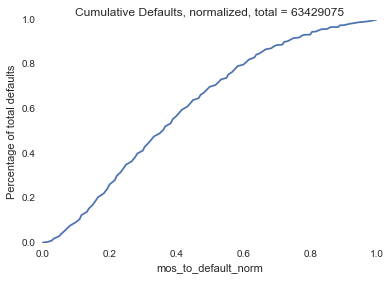

In [7]:
# defaulted_df makes a vector of obligors classified as defaulted
# may be more pythonic to use groupby
defaulted_df = lcd_temp[lcd_temp['Default_state']==1][['mos_to_default_norm','Default_amnt','grade']]

# 
defaulted_total = defaulted_df['Default_amnt'].sum()

# I'm not sure if there's a better way to write the below.   Sorting and 
defaulted_df.sort(columns = 'mos_to_default_norm', inplace=True)
defaulted_df.reset_index(inplace=True,drop=True)

# Got this code from Stack Exchange....very useful!
cum_defaults = defaulted_df.groupby('mos_to_default_norm').Default_amnt.sum().cumsum()

cum_defaults /= defaulted_total

# Now plot!

plt.title("Cumulative Defaults, normalized, total = %d" % round(defaulted_total,0))
plt.ylabel("Percentage of total defaults")
plt.xlabel("Normalized Time")
cum_defaults.plot()

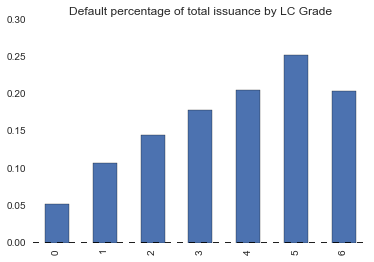

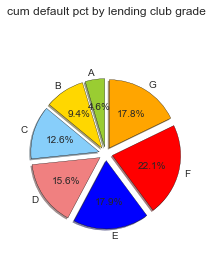

In [8]:
# Plot default pctage by ratings grade
default_by_grade = defaulted_df.groupby('grade')['Default_amnt'].sum()
total_issuance_by_grade = lcd_temp.groupby('grade')['loan_amnt'].sum()

# make a df out of these two series
defaults = pd.concat([total_issuance_by_grade,default_by_grade], axis=1)
defaults.columns = ('issuance','defaults')

# Default pctage = total defaults / total issuance 
defaults['cum_default_rate'] = defaults.defaults/defaults.issuance

defaults.reset_index(inplace=True)

plt.subplot(111)
defaults['cum_default_rate'].plot(kind='bar', title ='Default percentage of total issuance by LC Grade')
plt.show()

# Pie plotting code from Matplotlib.org 
plt.subplot(122)
labels = defaults.grade
sizes = defaults.cum_default_rate
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','blue','red','orange']
explode = (0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', shadow=True, startangle=90)

plt.title('cum default pct by lending club grade \n\n')
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

plt.show()

In [10]:
# Encode LC Loan sub grades using OHE for regression.
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

encoded_sub_grade = ohe.fit_transform(lcd_temp[['sub_grade_int']])

encoded_dataframe2 = pd.DataFrame(encoded_sub_grade, columns=('A1','A2','A3','A4','A5',
                                                         'B1','B2','B3','B4','B5',
                                                         'C1','C2','C3','C4','C5',
                                                         'D1','D2','D3','D4','D5',
                                                         'E1','E2','E3','E4','E5',
                                                         'F1','F2','F3','F4','F5',
                                                         'G1','G2','G3','G4','G5'))

print encoded_dataframe2.shape
print lcd_temp.shape

lcd_temp = pd.concat([lcd_temp, encoded_dataframe2], axis=1)

print lcd_temp.shape

(42452, 35)
(42452, 68)
(42452, 103)


## The code below is where the regressions are run.  Currently, I am using a simple logistic regression against one feature.   Next steps will be to use more features and explcitly feature selection.  Hopefully, I'll be able to also do better model selection and tuning.  

In [16]:
# Form of Recursive Feature Selection with Cross Validation
# class sklearn.feature_selection.RFECV(estimator, step=1, cv=None, scoring=None, 
#                                       estimator_params=None, verbose=0)[source]
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
import sklearn
import sklearn.linear_model as lm
import sklearn.grid_search as gs

# Define features, 
X = lcd_temp.drop(labels=('Default_state','Default_amnt'))
y = lcd_temp['Default_state']

#  Create a logistic regression estimator 
logreg = lm.LogisticRegression()

# Use RFECV to pick best features, using Stratified Kfold
rfecv =   RFECV(estimator=lm, step=1, cv=StratifiedKFold(y, 3),
              scoring='roc_auc')

rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)


ValueError: labels [('Default_state', 'Default_amnt')] not contained in axis

In [144]:
# Select Features and create the feature and target dfs. 
# FICO is a log scale...eg, FICO of 700 is 10x more likely to default than 800.   So we need to transform FICO feature
import math

# Create a calculated feature which represents the log of fico score (for later use)
# lcd_36M.loc[:,'fico_log'] = [math.log(j,10) for j in lcd_36M.fico_interp]

# Lets set up a vector which looks at only 3 year loans
lcd_36M = lcd_temp[lcd_temp['clean_term']==36]



# The below are all various feature selection iterations....to be improved
# X_Columns = ['fico_interp', 'dti','clean_rates','loan_amnt','mths_since_last_record','mths_since_last_delinq']
# X_Columns = ['fico_interp']
# X_Columns = ['A','B','C','D','E','F','G']
X_Columns = ['A1','A2','A3','A4','A5',
             'B1','B2','B3','B4','B5',
             'C1','C2','C3','C4','C5',
             'D1','D2','D3','D4','D5',
             'E1','E2','E3','E4','E5',
             'F1','F2','F3','F4','F5',
             'G1','G2','G3','G4','G5']

# I used concat as performing dropna on the entire dataset would present problems.  This also allows 
# Me to select different characteristics.   Coding could be way improved, I'm sure

lcd = pd.concat([lcd_36M[X_Columns],lcd_36M['Default_state']],axis=1).dropna()

# Assign features to X, responses to y.   
X = lcd[X_Columns]
y = lcd['Default_state']

In [145]:
# Create train and test sets using 50% of the set
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.60,random_state=123)

In [146]:
#  Calculate a logistic regression against the 2 features for now. 
# Use Cross Validation to create train, test samples from data


#  Run a logistic regression on the training set to predict y
logreg = lm.LogisticRegression()
logreg.fit(Xtrain, ytrain)
print logreg.coef_
print logreg.intercept_
print logreg.score(Xtest,ytest)

[[-1.2903542  -0.90106736 -0.73064118 -0.77244785 -0.54237704 -0.46367623
  -0.40461157 -0.10112884 -0.05463876 -0.1510082   0.06493251  0.11317053
   0.18334157  0.08936499  0.1064893   0.37105532  0.39180532  0.23297734
   0.29016523  0.04346082  0.55616879  0.52751482 -0.25618259 -0.39053695
   0.16724215 -0.10681799 -0.03498835  0.36078496 -0.01257034  0.53325968
   0.31996038 -0.25328003 -0.16442682  0.07254293  0.14572294]]
[-2.06079473]
0.89683296261


In [32]:
# Let's try to visualize features correlated to default.
# First, take xtrain, ytrain and create two dataframes depending on default status
# train = pd.DataFrame(Xtrain, columns = X.columns)
# train['default'] = ytrain
# train_nd = train[train['default']==0]
# train_d = train[train['default']==1]
# print Xtrain.shape
# plt.figure(figsize=(12,9))

#  plt.scatter(train_nd.fico_interp, train_nd.dti, alpha= 0.75,marker='+', c= 'b')
# plt.scatter(train_d.fico_interp, train_d.dti, marker='o', edgecolors = 'r', facecolors = 'none')
# plt.legend( ('no default', 'default'), loc='upper right')

In [ ]:
#  We should use feature reduction here to select top features from total.  


In [160]:
# Let's try to tune some logreg hyperparameters.   
# pipeline with scaling to select best C and penalty
# Use Cross Validation to create train, test samples from data


pipe = make_pipeline(preprocessing.StandardScaler(), lm.LogisticRegression())
C_range = 10.**np.arange(-5, 1)
penalty_options = ['l1', 'l2']

skf = StratifiedKFold(y, 3)
param_grid = dict(logisticregression__C=C_range, logisticregression__penalty=penalty_options)

grid = GridSearchCV(pipe, param_grid, cv=skf, scoring='roc_auc')
grid.fit(X, y)
print grid.best_score_
print grid.best_params_

0.596027103597
{'logisticregression__penalty': 'l2', 'logisticregression__C': 1.0000000000000001e-05}


In [161]:
# Use grid tuned classifier to predict probabilities, put in y_probas
y_probas = grid.predict_proba(X)[:,1]

In [162]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

from scipy import interp

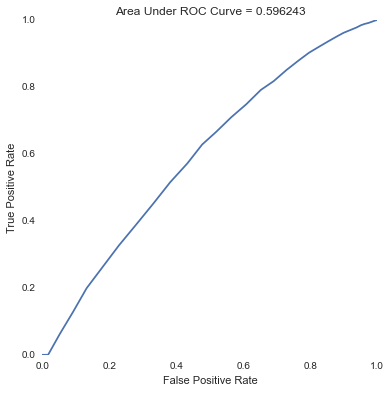

In [163]:
# Get classification probabilities from log reg 

# y_probas = logreg.predict_proba(X)[:,1]
# Generate ROC Curve from y and y_probas
fpr, tpr, thresholds= roc_curve(y, y_probas)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under ROC Curve = %f' % roc_auc_score(y, y_probas))


In [164]:
print roc_auc_score(y, y_probas)

0.596243300037


In [165]:
# Second iteration -  look at FICO scores as predictor

# Lets set up a vector which looks at only 3 year loans
lcd_36M = lcd_temp[lcd_temp['clean_term']==36]

# Create a calculated feature which represents the log of fico score (for later use)
# lcd_36M.loc[:,'fico_log'] = [math.log(j,10) for j in lcd_36M.fico_interp]

# The below are all various feature selection iterations....to be improved
# X_Columns = ['fico_interp', 'dti','clean_rates','loan_amnt','mths_since_last_record','mths_since_last_delinq']
X_Columns = ['fico_interp']
# X_Columns = ['A','B','C','D','E','F','G']
''' X_Columns = ['A1','A2','A3','A4','A5',
             'B1','B2','B3','B4','B5',
             'C1','C2','C3','C4','C5',
             'D1','D2','D3','D4','D5',
             'E1','E2','E3','E4','E5',
             'F1','F2','F3','F4','F5',
             'G1','G2','G3','G4','G5']
'''

# I used concat as performing dropna on the entire dataset would present problems.  This also allows 
# Me to select different characteristics.   Coding could be way improved, I'm sure

lcd = pd.concat([lcd_36M[X_Columns],lcd_36M['Default_state']],axis=1).dropna()

# Assign features to X, responses to y.   
X = lcd[X_Columns]
y = lcd['Default_state']

In [166]:
# Let's try to tune some logreg hyperparameters.   
# pipeline with scaling to select best C and penalty
# Use Cross Validation to create train, test samples from data
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn import preprocessing

pipe = make_pipeline(preprocessing.StandardScaler(), lm.LogisticRegression())
C_range = 10.**np.arange(-5, 1)
penalty_options = ['l1', 'l2']

skf = StratifiedKFold(y, 3)
param_grid = dict(logisticregression__C=C_range, logisticregression__penalty=penalty_options)

grid = GridSearchCV(pipe, param_grid, cv=skf, scoring='roc_auc')
grid.fit(X, y)
print grid.best_score_
print grid.best_params_

0.596027103597
{'logisticregression__penalty': 'l2', 'logisticregression__C': 1.0000000000000001e-05}


In [167]:
# Use grid tuned classifier to predict probabilities, put in y_probas
y_probas_FICO = grid.predict_proba(X)[:,1]

In [130]:
print X.columns

Index([u'fico_interp'], dtype='object')


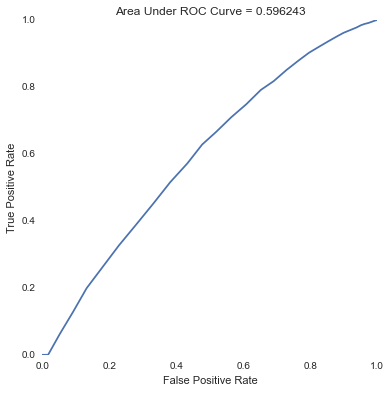

In [168]:
# Generate ROC Curve from y and y_probas
fpr, tpr, thresholds= roc_curve(y, y_probas_FICO)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under ROC Curve = %f' % roc_auc_score(y, y_probas))
